In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [2]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
parent_path = str(pathlib.Path(os.path.normpath('C:\\Users\\lms-puvvalat\\Documents\\GitHub\\2022-svsm-afib-group1\\')))

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [4]:
performance_dict = {
    "Model name": [],
    "Avg Accuracy": [],
    "Std Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "F1 score": [],
    "Run time": [],
    "TPS": []
}

moving_accuracy = {}

In [5]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath(parent_path + '/mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.42it/s]


In [6]:
X = combined_features[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'rmssd', 'iqr', 'mad', 'cov']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

In [7]:
# Decision tree
moving_accuracy['decision_tree'] = []
params = {
    "max_depth": list(range(1, 16))
}

print("random search started")
randomsearch = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=params, cv=splits)
randomsearch.fit(X, y)
print("random search completed")

acc_score = []
Truth = []
Output = []

total_time = 0
total_tests = 0

for train, test in tqdm(splits):
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    start_time = timeit.default_timer()
    pred_values = randomsearch.best_estimator_.predict(X_test)
    elapsed = timeit.default_timer() - start_time

    subject_acc = []
    total_correct = 0
    total_seen = 0
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)
    moving_accuracy['decision_tree'].append(subject_acc)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)
    total_time+=elapsed
    total_tests+=len(X_test)

tps = total_time/total_tests

print("---Run time is %s seconds ---" % total_time)
print("---Run time per subset is %s seconds ---" % tps)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(randomsearch.best_params_)
print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

results = pd.DataFrame(randomsearch.cv_results_).iloc[randomsearch.best_index_]
print(results)
scores = []
for x in range(len(rlist)):
    scores.append(results['split'+str(x)+'_test_score'])
    
print(scores)
print(np.mean(scores))

performance_dict['Model name'].append("Decision tree")
performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(total_time)
performance_dict['TPS'].append(tps)

random search started
random search completed


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.06it/s]


---Run time is 0.027295899984892458 seconds ---
---Run time per subset is 1.45533890949911e-07 seconds ---

Accuracy of each fold: 
 [0.9002050580997949, 0.9142801669740802, 0.9909502262443439, 0.8966872543514879, 0.9942218314282125, 0.9399513381995134, 0.9106702533064336, 0.9803568505483713, 0.9503315250150693, 0.9064605628220372, 0.9697960963907971, 0.9849663037843442, 0.8444444444444444, 0.978853815507202, 0.8996508728179551, 0.9720443875373452, 0.9773216354908127, 0.9875086745315753, 0.7594808355303184, 0.968683932346723, 0.9927484424471453, 0.9770462096043492, 0.9950535029275187]
Avg accuracy: 0.9431180095804294
Std of accuracy : 
0.05657038376262846
confusion matrix: 
[[94741  8144]
 [ 3271 81401]]
classification report: 
              precision    recall  f1-score   support

           0       0.97      0.92      0.94    102885
           1       0.91      0.96      0.93     84672

    accuracy                           0.94    187557
   macro avg       0.94      0.94      0.94 

In [8]:
performance_df = pd.DataFrame(performance_dict).set_index("Model name")
performance_df

,Avg Accuracy,Std Accuracy,Sensitivity,Specificity,Precision,F1 score,Run time,TPS
Model name,,,,,,,,
Decision tree,0.943118,0.05657,0.920844,0.961369,0.966627,0.94318,0.027296,1.455339e-07


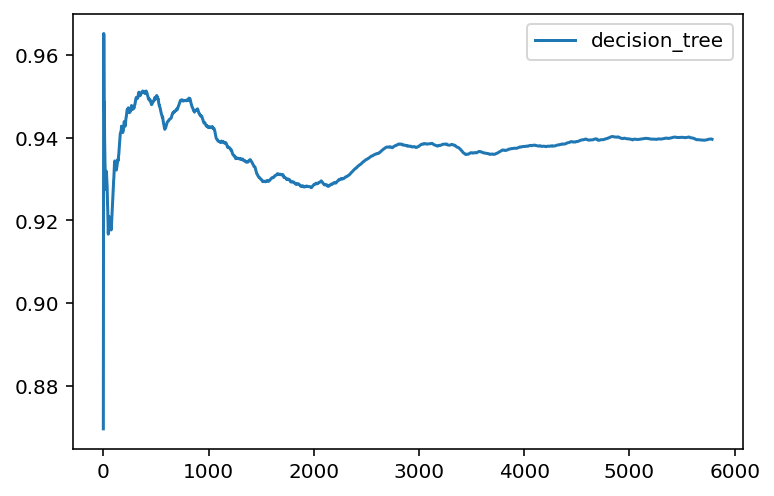

In [9]:
for classifier in moving_accuracy:
    minLen = len(moving_accuracy[classifier][0])
    for list in moving_accuracy[classifier]:
        if len(list)<minLen:
            minLen = len(list)

    for list in moving_accuracy[classifier]:
        list = list[:minLen]

    avg_list = [sum(sub_list) / len(sub_list) for sub_list in zip(*moving_accuracy[classifier])]
    plt.plot(avg_list, label = classifier)
    plt.legend()